In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from os import path

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Network Security/UNSW_NB15_testing-set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Network Security/UNSW_NB15_training-set.csv")

In [5]:
#Dropping the last columns of training set label and id
df_train = df_train.drop('id', 1)
df_train = df_train.drop('label', 1)
df_train.shape

<ipython-input-5-d284a21a0b7c>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_train = df_train.drop('id', 1)
<ipython-input-5-d284a21a0b7c>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_train = df_train.drop('label', 1)


(175341, 43)

In [6]:
#Dropping the last columns of testing set label and id
df_test = df_test.drop('id', 1)
df_test = df_test.drop('label', 1)
df_test.shape

<ipython-input-6-33eea86c10e9>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_test = df_test.drop('id', 1)
<ipython-input-6-33eea86c10e9>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_test = df_test.drop('label', 1)


(82332, 43)

In [7]:
# train dataset select numeric colom

num_col_train = df_train.select_dtypes(include='number').columns

# selecting categorical data attributes
cat_col_train = df_train.columns.difference(num_col_train)
cat_col_train = cat_col_train[1:]
cat_col_train

Index(['proto', 'service', 'state'], dtype='object')

In [8]:
# test dataset select numeric colom

num_col_test = df_test.select_dtypes(include='number').columns

# selecting categorical data attributes
cat_col_test = df_test.columns.difference(num_col_test)
cat_col_test = cat_col_test[1:]
cat_col_test

Index(['proto', 'service', 'state'], dtype='object')

In [9]:
#One-hot encoding
def one_hot(df, cols):

    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df

In [10]:
#Applying one hot encoding to train data
df_train = one_hot(df_train,cat_col_train)

<ipython-input-9-593a5f4671b5>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-9-593a5f4671b5>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-9-593a5f4671b5>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)


In [11]:
#Applying one hot encoding to test data
df_test = one_hot(df_test,cat_col_test)

<ipython-input-9-593a5f4671b5>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-9-593a5f4671b5>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)
<ipython-input-9-593a5f4671b5>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(each, 1)


In [12]:
# Find the columns that are in df_train but not in df_test
extra_columns = set(df_train.columns) - set(df_test.columns)

In [13]:
# Convert the set to a list if needed
extra_columns_list = list(extra_columns)

print("Columns in df_train but not in df_test:")
print(extra_columns_list)

Columns in df_train but not in df_test:
['state_PAR', 'state_ECO', 'proto_rtp', 'state_no', 'proto_icmp', 'state_URN']


In [14]:
# Get the set of column names in df_train
column_names_train = set(df_train.columns)

# Get the set of column names in df_test
column_names_test = set(df_test.columns)

# Find the common column names
common_column_names = column_names_train.intersection(column_names_test)

# Get the count of common column names
count_common_column_names = len(common_column_names)

print(f"Number of columns with the same name in both dataframes: {count_common_column_names}")

Number of columns with the same name in both dataframes: 189


In [15]:
# Get the common column names
common_column_names = df_train.columns.intersection(df_test.columns)

# Keep only the common columns in both dataframes
df_train = df_train[common_column_names]
df_test = df_test[common_column_names]


In [16]:
# take attack_colom into another variable temp
temp_1 = df_train.pop('attack_cat')
temp_2 = df_test.pop('attack_cat')

In [17]:
#Function to min-max normalize
def normalize(df, cols):

    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [18]:
#Normalizing training set
new_train_df = normalize(df_train,df_train.columns)
new_train_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,2.024634e-03,0.000520,0.000364,0.000018,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.083170e-02,0.001352,0.003463,0.000054,0.002867,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2.705215e-02,0.000728,0.001458,0.000026,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.802737e-02,0.001144,0.001093,0.000046,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,7.490901e-03,0.000936,0.000547,0.000039,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,1.500000e-07,0.000104,0.000000,0.000007,0.000000,0.111111,0.996078,0.000000,8.461366e-03,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
175337,8.429368e-03,0.000936,0.000729,0.000046,0.000024,0.000034,0.996078,0.992126,1.473996e-06,0.000219,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
175338,1.500000e-07,0.000104,0.000000,0.000007,0.000000,0.111111,0.996078,0.000000,8.461366e-03,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
175339,1.500000e-07,0.000104,0.000000,0.000007,0.000000,0.111111,0.996078,0.000000,8.461366e-03,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
#Normalizing testing set
new_test_df = normalize(df_test,df_test.columns)
new_test_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,1.833334e-07,0.000094,0.000000,0.000033,0.000000,0.090909,0.996078,0.000000,0.034238,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.333334e-07,0.000094,0.000000,0.000121,0.000000,0.125000,0.996078,0.000000,0.167236,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,8.333335e-08,0.000094,0.000000,0.000073,0.000000,0.200000,0.996078,0.000000,0.162187,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.000000e-07,0.000094,0.000000,0.000061,0.000000,0.166667,0.996078,0.000000,0.113895,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.666667e-07,0.000094,0.000000,0.000146,0.000000,0.100000,0.996078,0.000000,0.161427,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,0.015793,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.996047,0.000024,0.000108,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
#Appending class column to training set
new_train_df["Class"] = temp_1
new_train_df.head()

<ipython-input-20-8ec02d33ca04>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_train_df["Class"] = temp_1


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST,Class
0,0.002025,0.000520,0.000364,0.000018,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Normal
1,0.010832,0.001352,0.003463,0.000054,0.002867,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Normal
2,0.027052,0.000728,0.001458,0.000026,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Normal
3,0.028027,0.001144,0.001093,0.000046,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Normal
4,0.007491,0.000936,0.000547,0.000039,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Normal


In [21]:
#Appending class column to training set
new_test_df["Class"] = temp_2
new_test_df.head()

<ipython-input-21-c7b3a1d36faf>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_test_df["Class"] = temp_2


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST,Class
0,1.833334e-07,0.000094,0.0,0.000033,0.0,0.090909,0.996078,0.0,0.034238,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Normal
1,1.333334e-07,0.000094,0.0,0.000121,0.0,0.125000,0.996078,0.0,0.167236,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Normal
2,8.333335e-08,0.000094,0.0,0.000073,0.0,0.200000,0.996078,0.0,0.162187,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Normal
3,1.000000e-07,0.000094,0.0,0.000061,0.0,0.166667,0.996078,0.0,0.113895,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Normal
4,1.666667e-07,0.000094,0.0,0.000146,0.0,0.100000,0.996078,0.0,0.161427,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Normal


In [22]:
unique_values = new_train_df['Class'].unique()
unique_values

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [23]:
# Create a mapping dictionary
mapping = {
    'Normal': 0,
    'Backdoor': 1,
    'Analysis': 2,
    'Fuzzers': 3,
    'Shellcode': 4,
    'Reconnaissance': 5,
    'Exploits': 6,
    'DoS': 7,
    'Worms': 8,
    'Generic': 9
}

In [24]:
# Replace the values in the existing column with numerical labels
new_train_df['Class'] = new_train_df['Class'].map(mapping)

In [25]:
# Replace the values in the existing column with numerical labels
new_test_df['Class'] = new_test_df['Class'].map(mapping)


In [26]:
X_train = new_train_df.drop(columns=['Class'])
y_train = new_train_df['Class']


In [27]:
X_test = new_test_df.drop(columns=['Class'])
y_test = new_test_df['Class']

In [28]:
oos_pred = []
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

In [29]:
kfold = StratifiedKFold(n_splits=6,shuffle=True,random_state=42)
kfold.get_n_splits(X_train,y_train)

6

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import sklearn.preprocessing

In [31]:
input_shape = (X_train.shape[1], 1)

batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=64, padding="same", activation="relu", input_shape=input_shape))
model.add(MaxPooling1D(pool_size=10))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape=(128,)))
model.add(MaxPooling1D(pool_size=5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.6))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 188, 64)           4160      
                                                                 
 max_pooling1d (MaxPooling1  (None, 18, 64)            0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 18, 64)            256       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                        

In [33]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

detection_rates = []  # List to store True Positive Rates
false_positive_rates = []  # List to store False Positive Rates
average_f1_scores = []  # List to store average F1 scores
num_classes = 10
f1_scores = []

for train_index, test_index in kfold.split(X_train, y_train):
    train_X, test_X = X_train.iloc[train_index], X_train.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]

    print("train index:", train_index)
    print("test index:", test_index)
    print(train_y.value_counts())

    train_X_over, train_y_over = oversample.fit_resample(train_X, train_y)
    print(train_y_over.value_counts())

    x_columns_train = new_train_df.columns.drop('Class')
    x_train_array = train_X_over[x_columns_train].values
    x_train_1 = np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))

    dummies = pd.get_dummies(train_y_over)  # Classification
    outcomes = dummies.columns
    num_classes = len(outcomes)
    y_train_1 = dummies.values

    x_columns_test = new_train_df.columns.drop('Class')
    x_test_array = test_X[x_columns_test].values
    x_test_2 = np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))

    dummies_test = pd.get_dummies(test_y)  # Classification
    outcomes_test = dummies_test.columns
    num_classes = len(outcomes_test)
    y_test_2 = dummies_test.values

    model.fit(x_train_1, y_train_1, validation_data=(x_test_2, y_test_2), epochs=1)

    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_eval = y_test
    score = metrics.accuracy_score(y_eval, pred)
    oos_pred.append(score)

    # Calculate confusion matrix
    cm = confusion_matrix(y_eval, pred)

    # Calculate True Positive Rate (Detection Rate) for each class
    class_detection_rates = []
    for class_id in range(num_classes):
        tp = cm[class_id, class_id]
        fn = np.sum(cm[class_id, :]) - tp
        class_detection_rate = tp / (tp + fn)
        class_detection_rates.append(class_detection_rate)

    detection_rates.append(class_detection_rates)

    # Calculate False Positive Rate (FPR) for each class
    class_false_positive_rates = []
    for class_id in range(num_classes):
        fp = np.sum(cm[:, class_id]) - cm[class_id, class_id]
        tn = np.sum(cm) - (tp + fn + fp)
        class_false_positive_rate = fp / (fp + tn)
        class_false_positive_rates.append(class_false_positive_rate)

    false_positive_rates.append(class_false_positive_rates)

    # Calculate F1 score for each class
    class_f1_scores = []
    for class_id in range(num_classes):
        f1 = f1_score(y_eval == class_id, pred == class_id)
        class_f1_scores.append(f1)

    f1_scores.append(class_f1_scores)

    # Calculate average F1 score across all classes
    average_f1 = np.mean(class_f1_scores)
    average_f1_scores.append(average_f1)

    print("Validation score: {}".format(score))
    print("F1 scores for each class:", class_f1_scores)
    print("Average F1 score:", average_f1)


train index: [     0      1      2 ... 175336 175337 175340]
test index: [    16     18     21 ... 175333 175338 175339]
0    46666
9    33333
6    27827
3    15153
7    10220
5     8743
2     1667
1     1455
4      944
8      109
Name: Class, dtype: int64
0    46666
8    46666
9    33333
6    27827
3    15153
7    10220
5     8743
2     1667
1     1455
4      944
Name: Class, dtype: int64
2573/2573 [==============================] - 15s 5ms/step
Validation score: 0.6842539960161298
F1 scores for each class: [0.7573984339632132, 0.0, 0.0, 0.3669971734936516, 0.0, 0.5829646017699115, 0.6191717538360006, 0.0, 0.032217041119118266, 0.9794198671204019]
Average F1 score: 0.33381688713022967
train index: [     0      1      2 ... 175338 175339 175340]
test index: [     3      9     11 ... 175331 175332 175334]
0    46666
9    33333
6    27828
3    15153
7    10220
5     8742
2     1667
1     1455
4      945
8      108
Name: Class, dtype: int64
0    46666
8    46666
9    33333
6    27828
3   

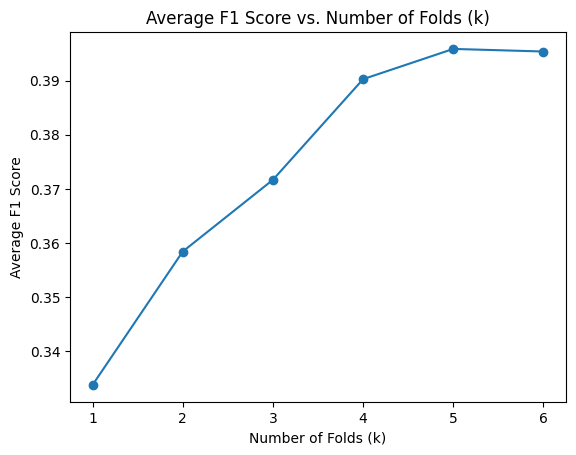

In [34]:
import matplotlib.pyplot as plt

k_values = range(1, 7)

# Plot average F1 scores for each fold
plt.plot(k_values, average_f1_scores, marker='o')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Average F1 Score')
plt.title('Average F1 Score vs. Number of Folds (k)')
plt.show()


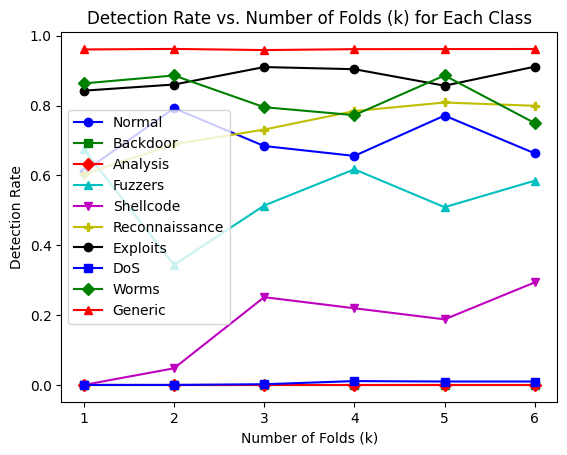

In [35]:
import matplotlib.pyplot as plt

k_values = range(1, 7)

class_names = ["Normal", "Backdoor", "Analysis", "Fuzzers", "Shellcode", "Reconnaissance", "Exploits", "DoS", "Worms", "Generic"]

# Create a list of symbols and line styles to use for indicating sharp turns
styles = ['b-o', 'g-s', 'r-D', 'c-^', 'm-v', 'y-P', 'k-o', 'b-s', 'g-D', 'r-^']

# Plot detection values for each class with different line styles
for class_id in range(10):
    plt.plot(k_values, [values[class_id] for values in detection_rates], styles[class_id], label=f'{class_names[class_id]}')

plt.xlabel('Number of Folds (k)')
plt.ylabel('Detection Rate')
plt.title('Detection Rate vs. Number of Folds (k) for Each Class')
plt.legend(loc='best')
plt.show()



In [36]:
X_test.shape

(82332, 188)

In [37]:
x_test_array = X_test[x_columns_train].values
x_test_1=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
pred = model.predict(x_test_1)
pred = np.argmax(pred,axis=1)
dummies_test = pd.get_dummies(y_test) # Classification

2573/2573 [==============================] - 14s 5ms/step


In [38]:
outcomes_test = dummies_test.columns
num_classes = len(outcomes_test)
Y_test = dummies_test.values

In [39]:
y_eval = np.argmax(Y_test,axis=1)

In [40]:
oos_pred

[0.6842539960161298,
 0.7483602973327503,
 0.7209954817082058,
 0.7182262060924064,
 0.7567288539085654,
 0.7211290871107224]

In [41]:
y_test.value_counts()

0    37000
9    18871
6    11132
3     6062
7     4089
5     3496
2      677
1      583
4      378
8       44
Name: Class, dtype: int64

In [42]:
dummies_test.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [43]:
from sklearn.metrics import confusion_matrix
confussion_matrix=confusion_matrix(y_eval, pred, labels=[0, 1, 2, 3, 4, 5,6, 7, 8, 9])

In [44]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

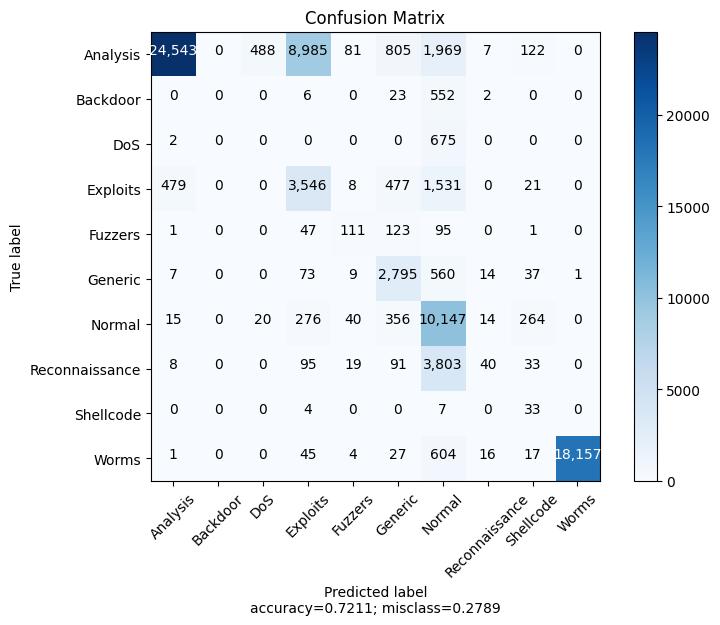

In [45]:
plot_confusion_matrix(cm           = confussion_matrix,
                      normalize    = False,
                      target_names = ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic','Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
                      title        = "Confusion Matrix")

In [46]:
target_class=[]
target_class=["Analysis","Backdoor","DoS", "Exploits", "Fuzzers", "Generic","Normal","Reconnaissance", "Shellcode", "Worms"]

In [47]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [48]:
pred1 = model.predict(X_test)

2573/2573 [==============================] - 12s 5ms/step


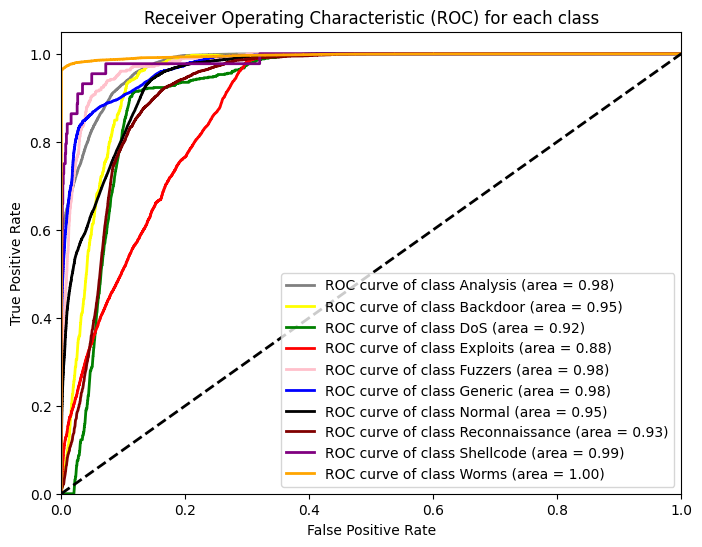

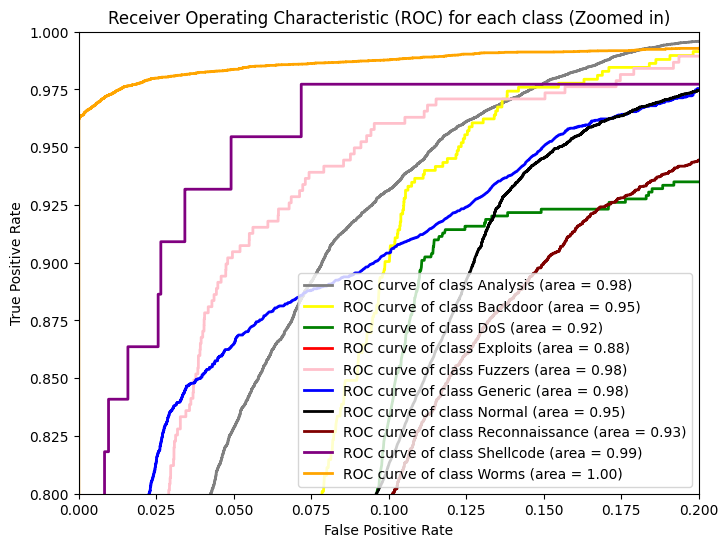

In [49]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
lw = 2

# Assuming that `y_test` and `pred1` are your test data for multiclass classification
# Convert `y_test` and `pred1` to NumPy arrays
y_test = np.array(y_test)
pred1 = np.array(pred1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(target_class)  # Number of classes

for i in range(n_classes):
    # Compute ROC curve for class i vs rest
    fpr[i], tpr[i], _ = roc_curve(y_test == i, pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['grey', 'yellow', 'green', 'red', 'pink', 'blue', 'black', 'maroon', 'purple', 'orange'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for each class')
plt.legend(loc='lower right')
plt.show()

# Zoom in on the plot
plt.figure(figsize=(8, 6))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for each class (Zoomed in)')
plt.legend(loc='lower right')
plt.show()
